In [19]:
from glob import glob
import numpy as np
from skimage import measure, io, transform
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import seaborn as sns
import warnings
import os


In [20]:
def bound_box(image, labeled_mask, aff=True, edgecolor='red', linewidth=1):
    """
    Plot bounding boxes around regions in the image corresponding to the labeled mask.

    Args:
        image (array-like): Input image.
        labeled_mask (array-like): Labeled mask of the regions in the image.
        aff (bool, optional): Flag to enable or disable plotting. Default is True (enabled).

    Returns:
        list: List of bounding boxes, where each bounding box is represented as [label, (min_row, min_col, max_row, max_col)].

    Example:
        bboxs = plot_bbox(image, labeled_mask, aff=True)
    """
    props = measure.regionprops(labeled_mask)
    bboxs = []

    for prop in props:
        label = prop.label
        min_row, min_col, max_row, max_col = prop.bbox
        bboxs.append([label, (min_row, min_col, max_row, max_col)])
        
    if aff:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(image, cmap='gray')
        ax.grid(False)
        ax.axis('off')

        for bbox in bboxs:
            label, (min_row, min_col, max_row, max_col) = bbox
            rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                             fill=False, edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(rect)
            # ax.text(min_col, min_row, str(label), color='white', fontsize=8,
            #         verticalalignment='top', bbox={'color': 'red', 'pad': 0, 'alpha': 0.5})

    plt.show()
    return bboxs

In [21]:

def apply_augmentations(image):
    """
    Apply rotation of 180 degrees, horizontal flip, and vertical flip to the given image.

    Parameters:
        image (numpy.ndarray): The input image as a numpy.ndarray (matrix).

    Returns:
        tuple: A tuple containing the original image and the three generated images - rotation of 180 degrees,
               horizontal flip, and vertical flip.
    """

    rotated_image = cv2.rotate(image, cv2.ROTATE_180)
    flipped_x_image = cv2.flip(image, 0)
    flipped_y_image = cv2.flip(image, 1)

    return image, rotated_image, flipped_x_image, flipped_y_image

In [22]:
def crop_resize(label_crop, new_shape):
    """
    Resize and pad the input image or array to match the desired new shape while preserving its aspect ratio.

    Parameters:
        label_crop (numpy.ndarray): The input image or array to be resized and padded.
        new_shape (tuple): The desired new shape as a tuple (height, width).

    Returns:
        numpy.ndarray: The resized and padded image or array with the specified new shape.
    """
    
    shapes = np.array(label_crop.shape)
    max_dim = np.max(shapes)
    scaled_shape = tuple((new_shape * shapes / max_dim).astype(int)) #to preserve the aspect ratio of the input image
    label_crop = transform.resize(label_crop, output_shape=scaled_shape, mode='edge')
    delta_y = (new_shape[1] - scaled_shape[1]) // 2
    delta_x = (new_shape[0] - scaled_shape[0]) // 2
    pad_width = ((delta_x, new_shape[0] - (delta_x + scaled_shape[0])),
                (delta_y, new_shape[1] - (delta_y + scaled_shape[1])))
    label_crop = np.pad(label_crop, pad_width, constant_values=np.min(label_crop))
    return label_crop

In [37]:
def crop_pad(label_crop, new_shape=(100, 35)):
    """
    Crop or pad a 2D array to the desired shape.

    Parameters:
        label_crop (numpy.ndarray): The input 2D array that needs to be cropped or padded.
        new_shape (tuple, optional): The desired output shape (height, width). Default is (100, 35).

    Returns:
        numpy.ndarray: The cropped or padded array with the specified new shape.
    """
    
    label_shape = np.array(label_crop.shape)
    output_shape = np.array(new_shape)

    # Check if cropping is needed (label_crop larger than new_shape)
    if label_shape[0] >= output_shape[0] or label_shape[1] >= output_shape[1] :
        delta = (label_shape - output_shape) // 2
        crop_slice = (
            slice(delta[0], delta[0] + output_shape[0]),
            slice(delta[1], delta[1] + output_shape[1])
        )
        
        label_crop = label_crop[crop_slice]
        label_shape = np.array(label_crop.shape)

    # If the input array is smaller, perform padding
    delta = (output_shape - label_shape) // 2
    pad_width = ((delta[0], output_shape[0] - label_shape[0] - delta[0]),
                 (delta[1], output_shape[1] - label_shape[1] - delta[1]))
    
    label_crop_padded = np.pad(label_crop, pad_width, constant_values=0)
    return label_crop_padded

In [24]:
def resize_and_save(img, mask, path_to_saving, new_shape, area_th=700):
    
    """
    Crop, resize, and save regions of interest from an image based on a corresponding mask.

    Parameters:
        img (numpy array): The input image as a NumPy array.
        mask (numpy array): The mask corresponding to the input image, where regions of interest are identified.
        path_to_saving (str): The directory path where the cropped and resized images will be saved.
        new_shape (tuple): A tuple representing the new shape (height, width) to which each crop will be resized.
        area_th (int, optional): The minimum area threshold for regions to be saved. Regions with an area less than this
                                 threshold will be ignored. Default is 700.

    Returns:
        None
    """
        
    print(f"Saving crops with area > {area_th}")
    props = measure.regionprops(mask)
        
    for prop in props:
        label = prop.label
        min_row, min_col, max_row, max_col = prop.bbox
        
        if prop.area > area_th:  # saving only the not too small nuclei
            label_crop = crop_resize(img[min_row:max_row, min_col:max_col], new_shape)
            img1,img2,img3,img4 = apply_augmentations(label_crop)
            
            io.imsave(f"{path_to_saving}{label}_org.png", (img1 * 255).astype(np.uint8))
            io.imsave(f"{path_to_saving}{label}_rot.png", (img2 * 255).astype(np.uint8))
            io.imsave(f"{path_to_saving}{label}_flipx.png", (img3 * 255).astype(np.uint8))
            io.imsave(f"{path_to_saving}{label}_flipy.png", (img4 * 255).astype(np.uint8))
    
    print(f"All labels saved to {path_to_saving}")

In [25]:
Path_masks = "./masks_channel_1/220429_ MCF10A  laminAC fibro phallo pattern mars 2022/masks/*PNG"
Path_masks = glob(Path_masks) 
Path_imges = "./masks_channel_1/220429_ MCF10A  laminAC fibro phallo pattern mars 2022/images/*PNG"
Path_images = glob(Path_imges) 

number of labels 320


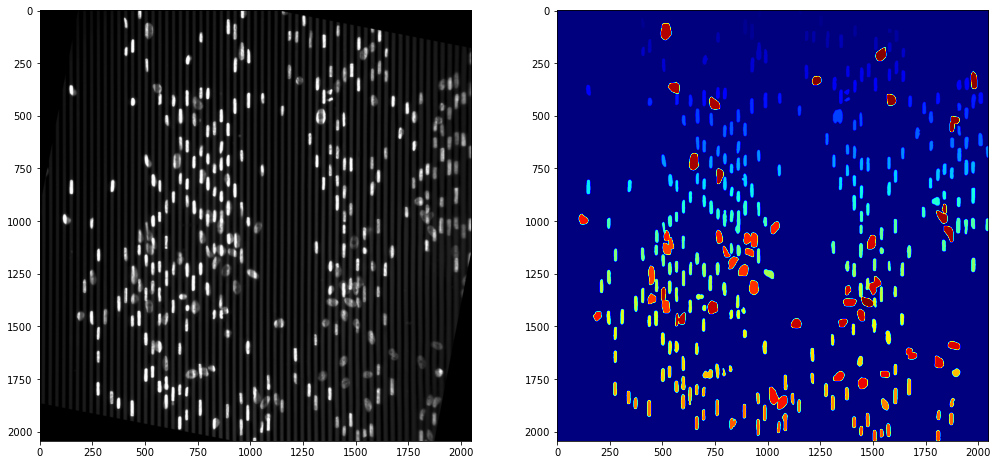

In [26]:
mask_path = Path_masks[0]
image_path = Path_images [0]
mask = io.imread(mask_path)
image = io.imread(image_path)
print ("number of labels" , np.max(mask))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))
pl1 = axes[0].imshow(image, cmap='gray') 
pl2 = axes[1].imshow(mask, cmap='jet') 
plt.show()

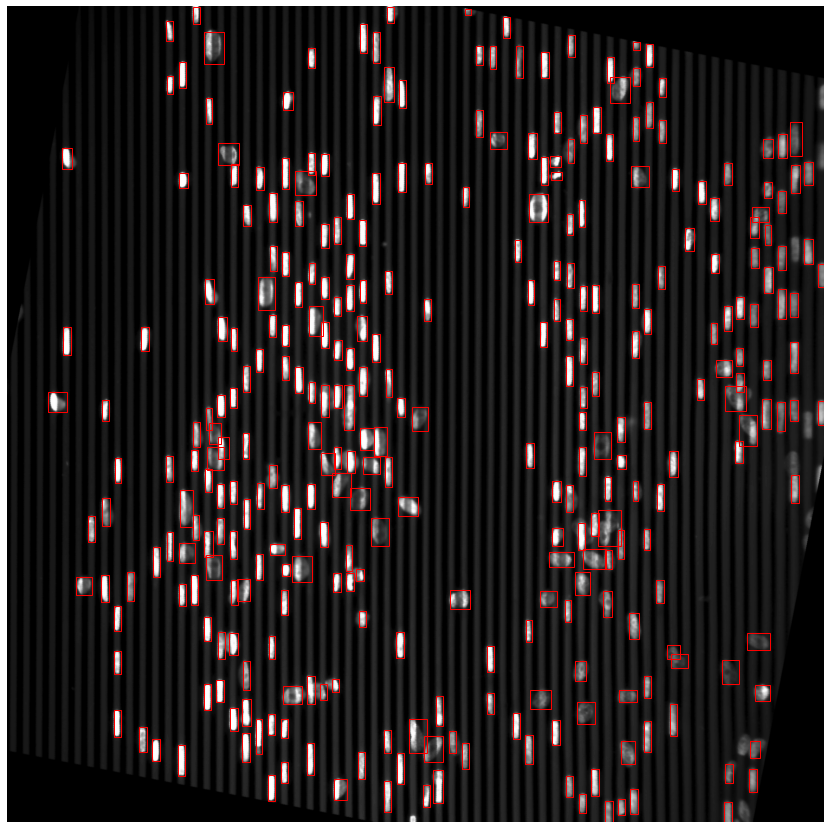

In [27]:
bboxs = bound_box(image, mask)

In [28]:
def histogram_distbox_Feature(data_list, feature):
    """
    A function to plot the distribution and box plot of a feature
    
    Parameters:
        data_list (list): A list containing the data for the specified feature.
        feature (str): The name of the feature for labeling the plots.
    """
        
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    ax1 = sns.histplot(data=data_list, ax=axes[0], kde=True, bins=30)
    ax2 = sns.boxplot(data_list, ax=axes[1],whis=2.5)
    ax1.set_xlabel(feature)
    ax1.set_title("Histogram and KDE")
    ax2.set_xlabel(feature)
    ax2.set_title("Box Plot")
    plt.show()
    print("mean " + feature ,np.mean(data_list))
    


In [29]:
def properties_ROI(img, mask,aff=True):
    """
    Calculate the area, height, and width of each bounding box of the regions of interest (ROI),
    and optionally generate and display histograms of these properties.

    Parameters:
        img (numpy.ndarray): The input image.
            An array representing the image to analyze.

        mask (numpy.ndarray): Binary mask indicating regions of interest (ROI).
            The mask should have the same dimensions as the input image (img).

        aff (bool, optional): Whether to display histograms of the calculated properties.

    Returns:
        tuple: A tuple containing three lists, each representing the calculated properties of
        the bounding boxes of ROIs.
    """
    props = measure.regionprops(mask)
    areas = []
    heights = []
    widths = []
    
    for prop in props:    
        min_row, min_col, max_row, max_col = prop.bbox
        areas.append(prop.area)
        heights.append(max_row - min_row)
        widths.append(max_col - min_col)
    
    if aff:
        histogram_distbox_Feature(areas, "area")
        histogram_distbox_Feature(heights, "height")
        histogram_distbox_Feature(widths, "width")
    
    return(areas,heights,widths)

c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


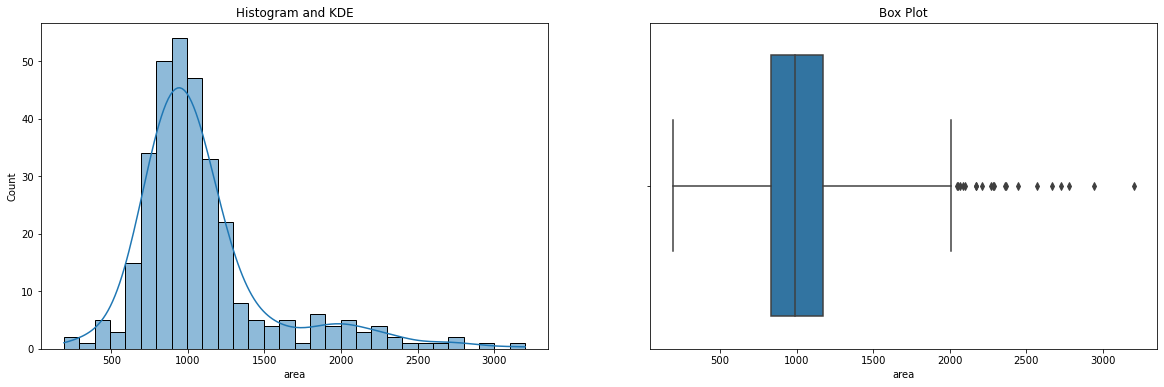

mean area 1093.09375


c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


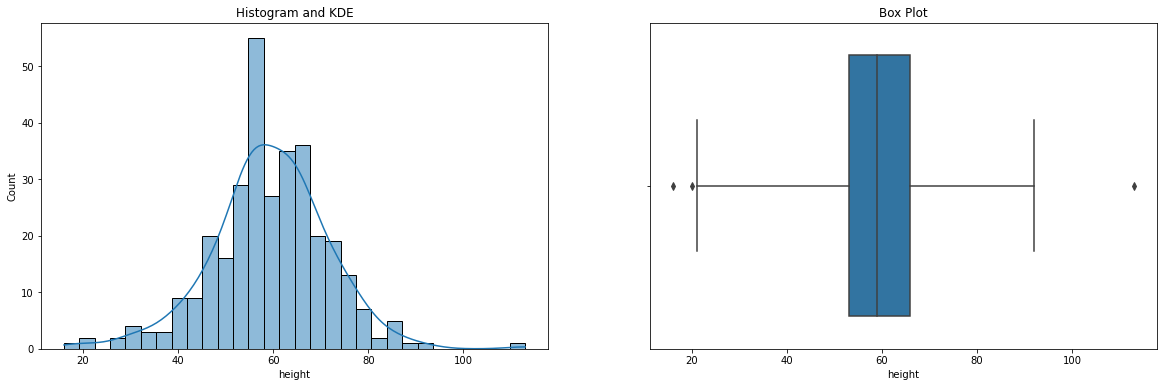

mean height 59.2875


c:\Users\souhm\anaconda3\envs\allwhatyouneed\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


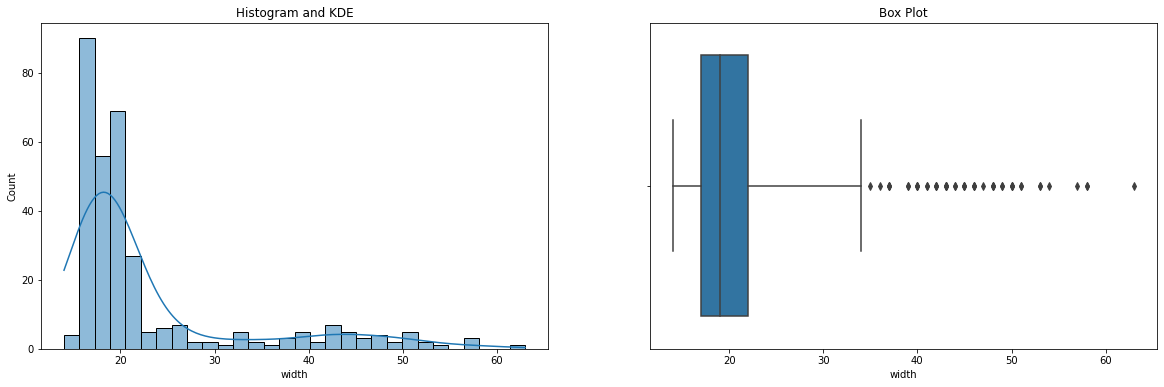

mean width 22.9


In [30]:
areas,heights,widths = properties_ROI(image,mask)

image label =  50


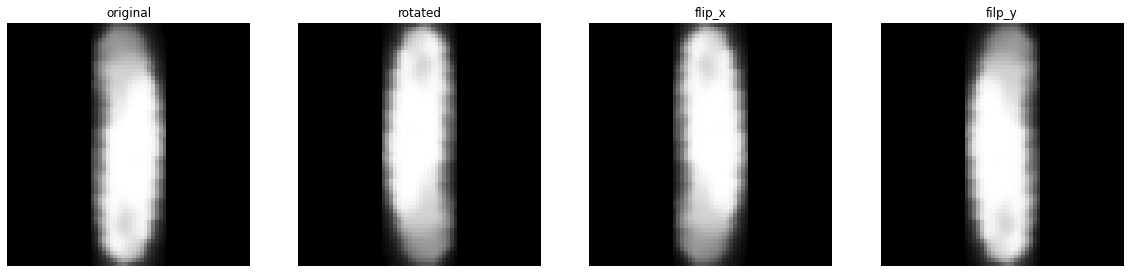

image label =  100


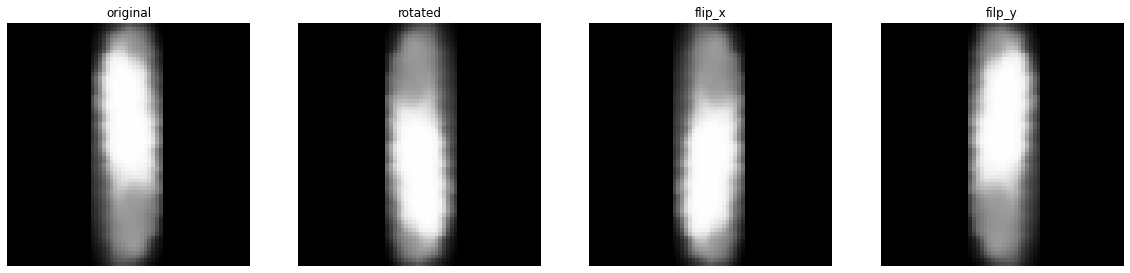

image label =  150


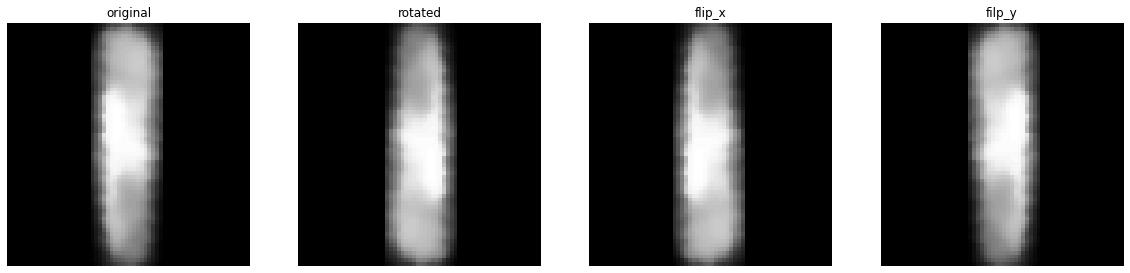

image label =  200


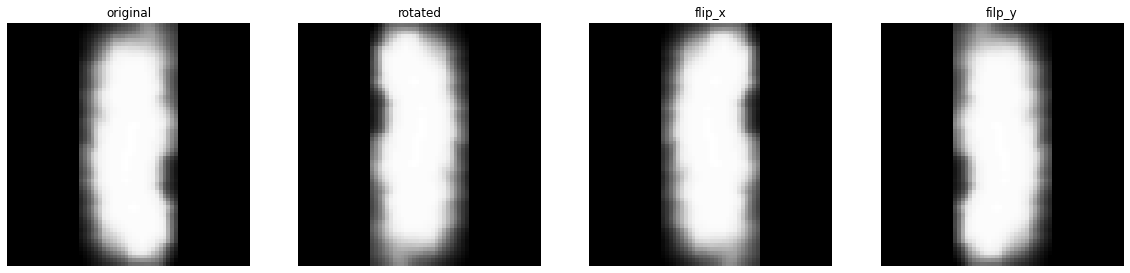

image label =  250


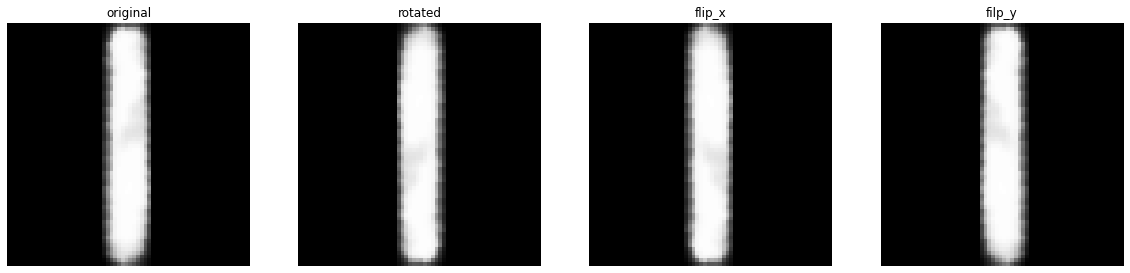

image label =  300


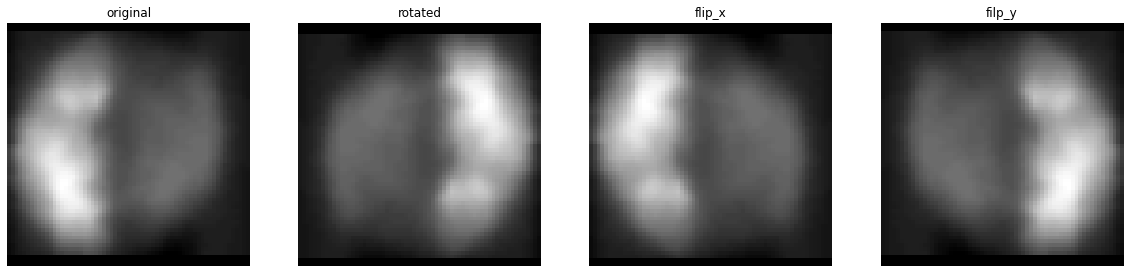

In [31]:
from image_utils import load_images_from_path,crop,show_images
area_th = np.percentile(areas,0.15)
new_shape = (64,64)
props = measure.regionprops(mask)
q=50
titles = ["original","rotated","flip_x","filp_y"]
for prop in props:
    label = prop.label
    min_row, min_col, max_row, max_col = prop.bbox
    if prop.area > area_th: 
        label_crop = crop_resize(crop(image, min_row, max_row, min_col, max_col), new_shape)
        if label%q==0:
            print("image label = ",label)
            l = list(apply_augmentations(label_crop))
            show_images(l,titles)
            

image label =  50


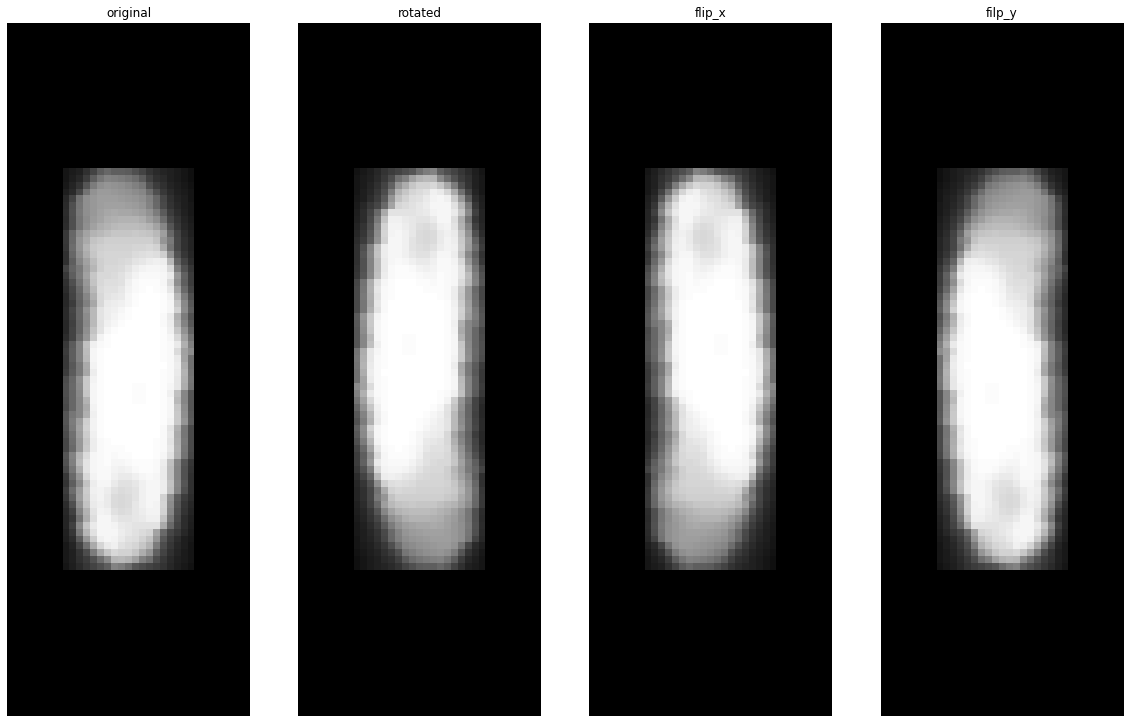

image label =  100


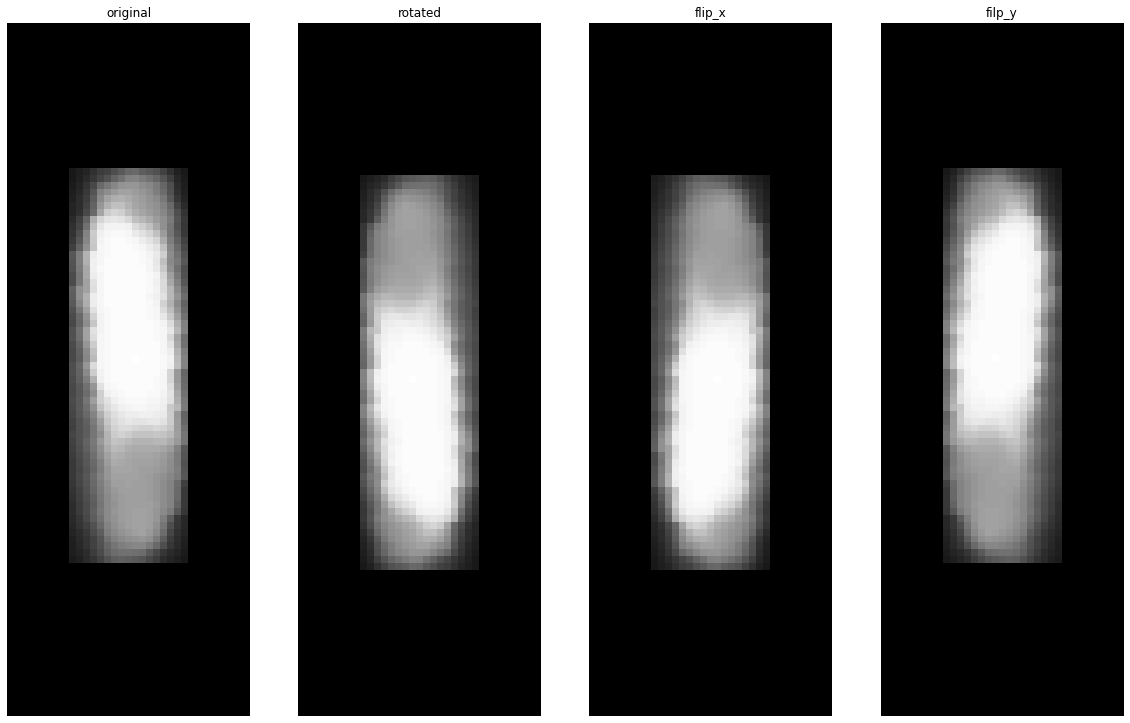

image label =  150


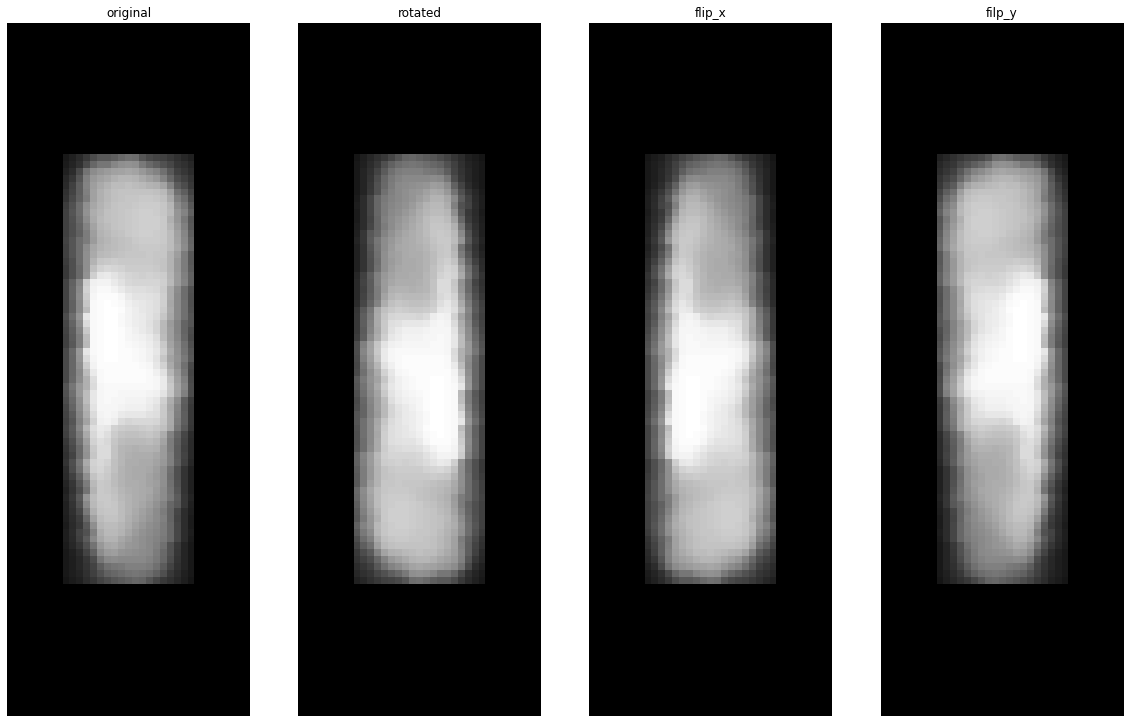

image label =  200


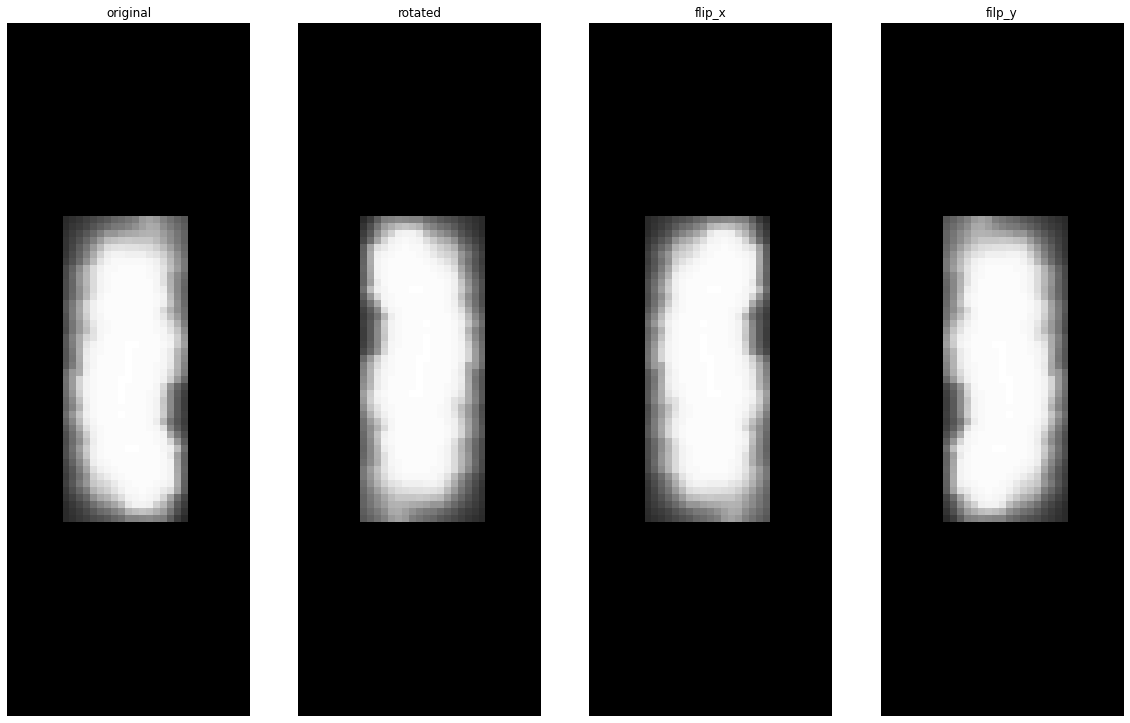

image label =  250


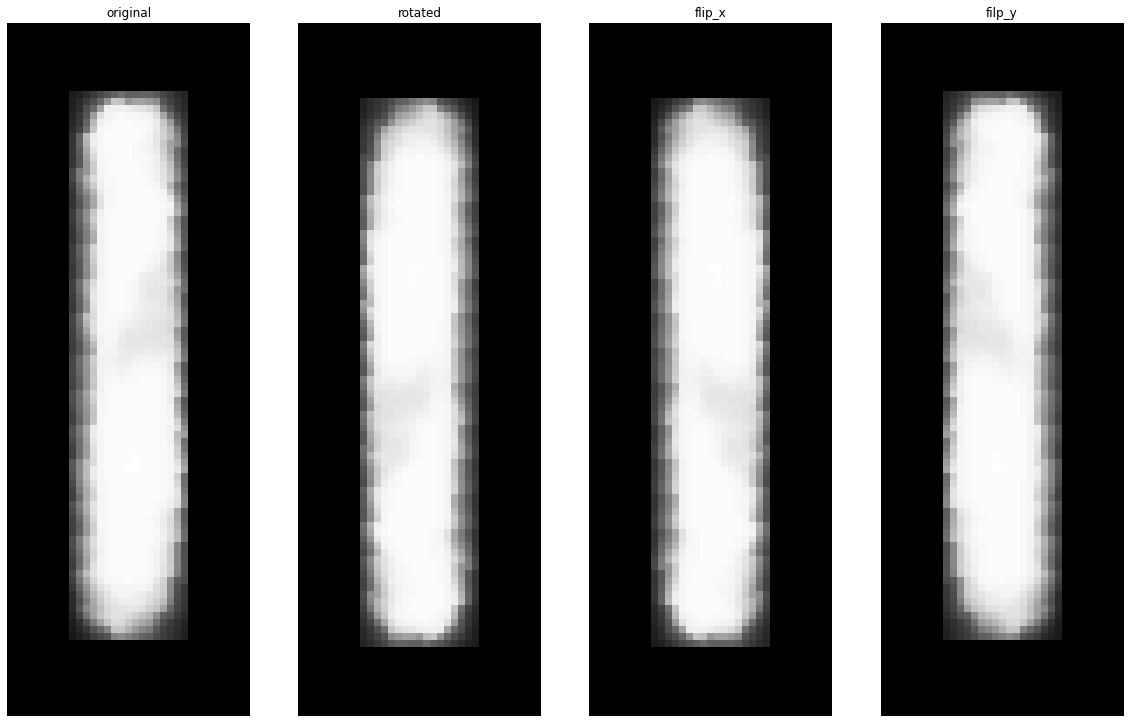

image label =  300


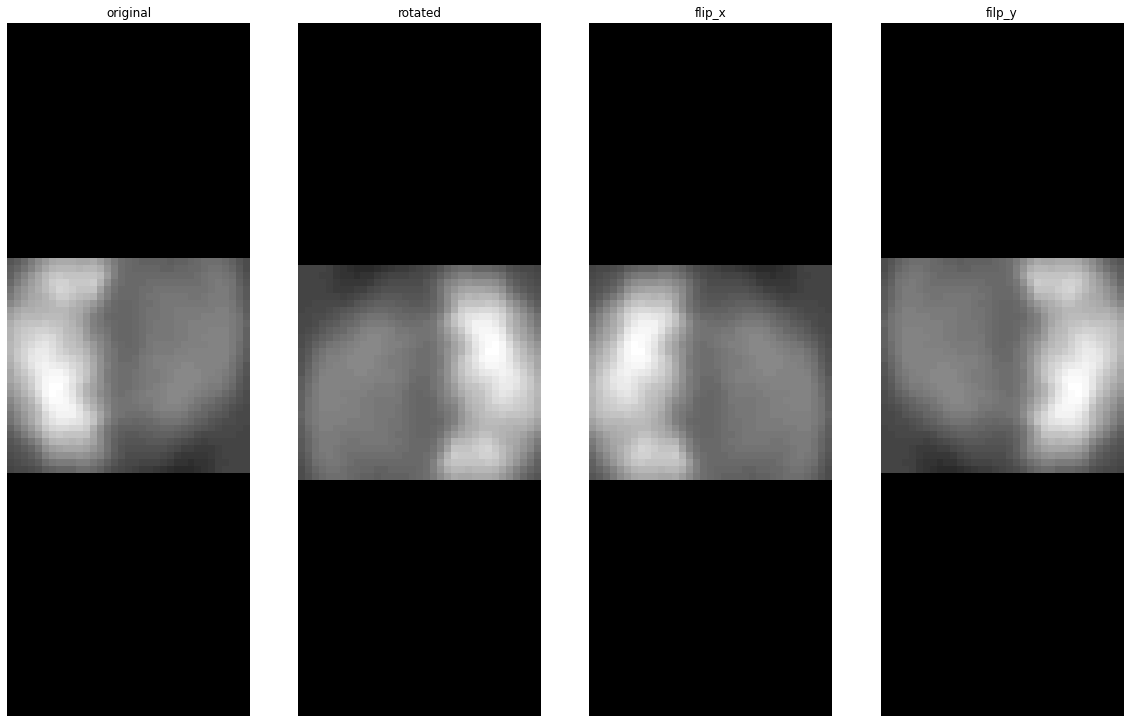

In [39]:
from image_utils import load_images_from_path,crop,show_images
area_th = np.percentile(areas,0.15)
new_shape = (100,35)
props = measure.regionprops(mask)
q=50
titles = ["original","rotated","flip_x","filp_y"]
for prop in props:
    label = prop.label
    min_row, min_col, max_row, max_col = prop.bbox
    if prop.area > area_th: 
        label_crop = crop_pad(crop(image, min_row, max_row, min_col, max_col), new_shape)
        if label%q==0:
            print("image label = ",label)
            l = list(apply_augmentations(label_crop))
            show_images(l,titles)

In [33]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Error creating folder: {e}")

In [34]:
def cropping_loop(data_path = "./masks_channel_1/", crop_shape=(64,64), saving_path="./cropped_cells/"):
    
    data_folders = os.listdir(data_path)
    for folder in data_folders: 
        
        PATH_masks = os.path.join(data_path, folder,'masks')
        PATH_images = os.path.join(data_path, folder,'images')
        mask_paths = glob(PATH_masks +"/*PNG")
        image_paths = glob(PATH_images +"/*PNG")
        save_path = os.path.join(saving_path, folder)
        for i in range (len(mask_paths)):
            mask = io.imread(mask_paths[i])
            image = io.imread(image_paths[i])
            PATH = os.path.join(save_path,str(image_paths[i][-11:-4]))
            create_folder_if_not_exists(PATH)
            resize_and_save(image, mask, PATH+"/", crop_shape)
           

In [35]:
#cropping_loop()